# MIDAS Example

Download `UNSW-NB15_1.csv`, `UNSW-NB15_2.csv`, `UNSW-NB15_3.csv`, `UNSW-NB15_4.csv` from https://researchdata.edu.au/unsw-nb15-dataset/1425943 and put them into `data/`: 

```
data
├── UNSW-NB15_1.csv
├── UNSW-NB15_2.csv
├── UNSW-NB15_3.csv
└── UNSW-NB15_4.csv
```

## Import Libraries

In [1]:
import pandas as pd
import plotly.express as px

from sklearn.metrics import roc_auc_score
from datetime import datetime, timezone
from pathlib import Path
from MIDAS import MIDASR

## Configuration

In [2]:
data_dir_path = Path('data')

# csv header
header = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 
    'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 
    'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 
    'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 
    'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label',
]

# required cols
usecols = ['srcip', 'dstip', 'service', 'stime', 'Label']

# midas-r config
num_row = 8
num_col = 4096
factor = 0.5

## Read Data

In [3]:
df = pd.concat((pd.read_csv(f, names=header, usecols=usecols) for f in data_dir_path.iterdir()))

# select dns only
df = df[df['service'] == 'dns']

# round connections into hour bucket
df['datetime_hour'] = df['stime'].apply(lambda x: datetime.fromtimestamp(x, tz=timezone.utc)).dt.floor('h')

# sort by original timestamp
df = df.sort_values('stime').reset_index(drop=True)

## Initialise MIDAS

In [4]:
class Scorer:
    def __init__(self, num_row: int, num_col: int, factor: float, base_timestamp: int):
        self.midas = MIDASR(num_row=num_row, num_col=num_col, factor=factor)
        self.base_timestamp = base_timestamp
    
    def get_score(self, src, dst, timestamp):
        # MIDAS author suggest that timestamp starts from 1, therefore we set a base here
        timestamp = int(timestamp - self.base_timestamp + 1)
        return self.midas.add_edge(src, dst, timestamp)

In [5]:
midas = Scorer(num_row=num_row, num_col=num_col, factor=factor, base_timestamp=1421924400)

## Scoring

In [6]:
df['score'] = df.apply(func=(lambda row: midas.get_score(row.srcip, row.dstip, row.datetime_hour.timestamp())), axis=1)

## Plot Score Distribution

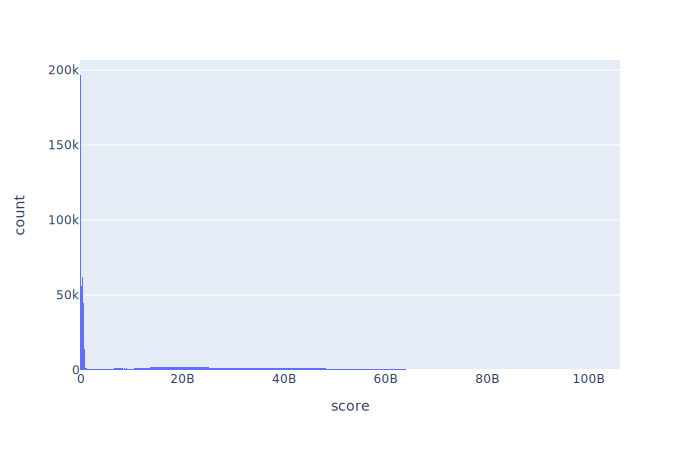

In [7]:
fig = px.histogram(df, x='score')
fig.show('svg')

## Calculate ROC Score

In [8]:
roc_auc_score(df['Label'], df['score'])

0.7876835997224383